In [1]:
from uproot_io import Events, View
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

print("Running...")
toc = time.perf_counter()
#ALL SETUP

thr_std=0.2
n_events=9310


E = Events("CheatedRecoFile_1.root")


view_u = View(E, "u")
view_v = View(E, "v")
view_w = View(E, "w")


u_x = view_u.x
u_z = view_u.z
u_adc = view_u.adc
u_truevtx_z = view_u.true_vtx_z
u_truevtx_x = view_u.true_vtx_x


v_x = view_v.x
v_z = view_v.z
v_adc = view_v.adc
v_truevtx_z = view_v.true_vtx_z
v_truevtx_x = view_v.true_vtx_x

w_x = view_w.x
w_z = view_w.z
w_adc = view_w.adc
w_truevtx_z = view_w.true_vtx_z
w_truevtx_x = view_w.true_vtx_x

tic = time.perf_counter()
print("All data loaded in", tic-toc, "seconds")

Running...
All data loaded in 146.75040339999998 seconds


In [52]:
def AoI(plane, event_number, thresholding=True, no_std=thr_std):
    #given plane and event number, extract required information and threshold if required
    if plane=="u":
        AoI_x = u_x[event_number]
        AoI_z = u_z[event_number]
        AoI_adc = u_adc[event_number]
        AoI_truevtxz = u_truevtx_z[event_number]
        AoI_truevtxx = u_truevtx_x[event_number]
    elif plane=="v":
        AoI_x = v_x[event_number]
        AoI_z = v_z[event_number]
        AoI_adc = v_adc[event_number]
        AoI_truevtxz = v_truevtx_z[event_number]
        AoI_truevtxx = v_truevtx_x[event_number]
    elif plane=="w":
        AoI_x = w_x[event_number]
        AoI_z = w_z[event_number]
        AoI_adc = w_adc[event_number]   
        AoI_truevtxz = w_truevtx_z[event_number]
        AoI_truevtxx = w_truevtx_x[event_number]
    else:
        print("PLane not u,v,w")
        
    if thresholding:
        mean = np.average(AoI_adc)
        std = np.std(AoI_adc)
        AoI_x = AoI_x[(mean-no_std*std<AoI_adc)]
        AoI_z = AoI_z[(mean-no_std*std<AoI_adc)]
        AoI_adc = AoI_adc[(mean-no_std*std<AoI_adc)]
        
    AoI = [AoI_z, AoI_x, AoI_adc]
    return AoI, (AoI_truevtxz,AoI_truevtxx)
AoI, true = AoI("u", 21)

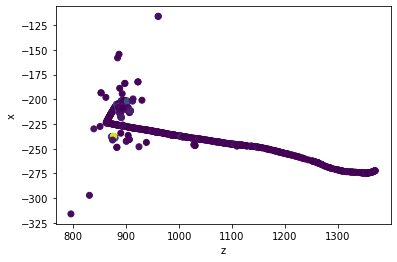

In [53]:
def plotter(AoI, thresholding=True, no_std=thr_std):
    
    AoIz, AoIx, AoIadc = AoI
    
    plt.scatter(AoIz, AoIx, c=AoIadc, cmap="viridis")
    #plt.title(str(plane)+" plane")
    plt.xlabel("z")
    plt.ylabel("x")
    return 0
plotter(AoI)
plt.show()

In [54]:
def pick_xz(AoI, i, thresholding=True, no_std=thr_std):
    AoI_x, AoI_z, AoI_adc = AoI
    return AoI_z[i], AoI_x[i]

In [55]:
def line_finder(AoI, point_number, scale=5, wiggle=0.05, know_prev_point=False, prev_point_number=None):
    AoI_z, AoI_x, AoI_adc = AoI
    L = len(AoI_x)
    LL = L-1
    if (point_number+scale>LL): #make sure scale either side of the point in question doesn't leave range
        scale = LL-point_number
    if (point_number-scale<0) and not(know_prev_point): #this one is only necessary if have to scan prev points
        scale = point_number
    if scale==0: #cannot do anything with ends of array
        return []
    
    centre = np.array([AoI_z[point_number], AoI_x[point_number]])
    
    if know_prev_point:
        pre_rel_z = AoI_z[prev_point_number] - centre[0]
        pre_rel_x = AoI_x[prev_point_number] - centre[1]
    else:
        pre_rel_z = AoI_z[point_number-scale:point_number] - centre[0]
        pre_rel_x = AoI_x[point_number-scale:point_number] - centre[1]
    
    #if know_prev_point pre_rel_x/z = (z,x)
        #therefore pretheta has one value
    #otherwise pre_rel_x/z = ([z], [x])
        #therefore pretheta is an array
    
    
    pre_theta = np.arctan2(pre_rel_x,pre_rel_z)
    
    
    
    post_rel_z = AoI_z[point_number+1:point_number+scale+1] - centre[0]
    post_rel_x = AoI_x[point_number+1:point_number+scale+1] - centre[1]
    post_theta = np.arctan2(post_rel_x,post_rel_z)
    post_r = (post_rel_z**2 + post_rel_x**2)**0.5
    
    #for both scenarios post_rel_x/z is an array
    
    if know_prev_point:
        theta_max = pre_theta + np.pi + wiggle #single value
        theta_min = theta_max - 2*wiggle #single value
        for j in range(scale):
            if (post_theta[j]>theta_min and post_theta[j]<theta_max): #run through post values and return first that fits
                return [prev_point_number, point_number, point_number+j+1]
        return []
    

    
    for i in range(scale):
        pre_theta[-i-1] += np.pi
        theta_max = pre_theta[-i] + np.pi + wiggle
        theta_min = theta_max - 2*wiggle
        for j in range(scale):
            if (post_theta[j]>theta_min and post_theta[j]<theta_max):
                return [point_number-i-1, point_number, point_number+j+1]
    
    return []
line_finder(AoI, 16, know_prev_point=True, prev_point_number=1)

[]

In [ ]:
from tqdm import tqdm

def line_collater(AoI, scale=5, wiggle=0.05, plot=True):
    AoI_z, AoI_x, AoI_adc = AoI
    L = len(AoI_z)
    
    lines = []

    for i in range(1,L):
        line = []
        x = line_finder(AoI, i, scale, wiggle)
        
        if (x!=[]):
            line.append(x[0])
            line.append(x[1])
        while (x!=[]):
            line.append(x[-1])
            x = line_finder(AoI, x[-1], scale, wiggle, know_prev_point=True, prev_point_number=x[-2])
            
            
        lines.append(line)
        lines = [i for i in lines if i != []]
        if plot:
            for i in tqdm(lines):
                plt.plot([AoI_z[j] for j in i],[AoI_x[j] for j in i], 'ro')
            plotter(AoI)
            plt.show()
            
    return lines

q = line_collater(AoI)
print(q)

In [ ]:
def line_ploter(AoI, scale, wiggle):
    lines = line_collater(AoI, scale, wiggle)

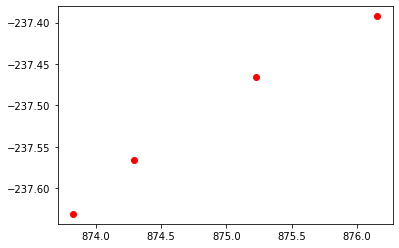

In [8]:
AoI_z, AoI_x, AoI_adc = AoI
for i in x:
    plt.plot(AoI_z[i],AoI_x[i], 'ro')
#plotter(AoI)
plt.show()